
# Zebrafish Opsin spectra
#### by MJY Zimmermann & P Bartel


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import scipy as scipy
from scipy import stats, integrate
from scipy.optimize import minimize
from scipy.signal import savgol_filter as savgol
from IPython.display import Image,HTML,display

## Setting global parameters
Here we defined the max absorbance for each cone opsin present in the Zebrafish. The following values are taken from 
[Allison et al](https://www.cambridge.org/core/journals/visual-neuroscience/article/visual-pigment-composition-in-zebrafish-evidence-for-a-rhodopsinporphyropsin-interchange-system/D7824490079257A101123EBD593C153C) (Visual pigment composition in zebrafish:Evidence for a rhodopsin–porphyropsin interchange system, 2004)

In [2]:
PeakWavelength = [565, 482, 411, 361]      # Peak opsin absorbance wavelengths in nm(R,G,B,UV)
nLED = len(PeakWavelength)                 # Number of LED (4 in our tested stimulator)
nCone = nLED                               # Number of cones in the considered animal modelb

Figure Parameters

In [3]:
SpectraRange = (300,700)                   # Spectrum Range in nm displayed on the various graph 
FigureSize = (15,10)                       # Set the size of all spectra figures
FigureFontSize = 20                        # Set the font size for spectra figure labels
FigureTitleSize = 25                       # Set the font size for spectra figure titles
colour = ['r','g','b','m']                 # Set colour array for traces
Colour = ['r--','g--','b--','m--']         # Set colour array for traces

PMT1_min = 520                             # PMT 1 bandpass filter low wavelength (nm)
PMT1_max = 550                             # PMT 1 bandpass filter high wavelength (nm)
PMT2_min = 615                             # PMT 2 bandpass filter low wavelength (nm)
PMT2_max = 645                             # PMT 2 bandpass filter high wavelength (nm)

 Set a "rainbow" gradient that attributes a given wavelentgh (in nm) to its approximate RGB color value

C:\Users\Maxime\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


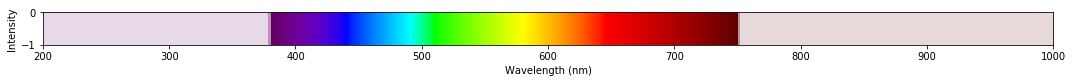

In [4]:
''' 
This part of the code is taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python.
Based on Dan Bruton's code: http://www.physics.sfasu.edu/astro/color/spectra.html       
''' 

def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.15
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(15,1.25), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)
#plt.plot(wavelengths, spectrum, color='darkred')

y = np.linspace(0, -1, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.ylim(-1,0)
plt.fill_between(wavelengths, spectrum,  8, color='w');


## Extract Spectrometer Recording to obtain LED spectra profile 
To determine the LEDs spectra, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable.

The following script is configured by default for ThorLab Spectrometer recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified

In [5]:
'''                          Spectrometer Recording General Parameters

The directory has to be modified to its new location.
Reference traces used here can be found in \open-visual-stimulator\calibration-zebrafish\data\spectrometer-recording

                                                                                                                    '''


os.chdir(r"C:\Users\Maxime\Documents\GitHub\Multi-Chromatic-Stimulator\Spectrum Calibration\Recording") 


nLoops = 1                           # Number of recording loop (5 in the submitted example)
nPoints = 100                        # Number of recording point per LED (100 in the current example (from 1 to 100% light intensity with an increment of 1))
SpectraNumber = nLoops*nLED*nPoints  # Total recording point number
FirstPoint = 33                      # Start of the recording point (33 in the submitted example)
SpectraStart = 19                    # First recording point (in our example: Spectrum000000019)
lenSpectra = 9                       # Length of the file string number (9 for ThorLab Spectrometer)

Spectra = []
for j in range(0,SpectraNumber):
    FileNumber = str(SpectraStart+j)
    FileNumber = FileNumber.rjust(lenSpectra,'0')
    FileName = 'Spectrum'+FileNumber+'.csv'
    a = np.asarray(pd.read_csv(FileName))[FirstPoint:-1,:].reshape(-1)
    a2 = np.asarray([a[i][17:] for i in range(a.shape[0])]).astype(float)
    Spectra.append(a2)
    
Spectra = np.asarray(Spectra)
WvsX = np.asarray([a[i][:16] for i in range(a.shape[0])]).astype(float)
Spectra=Spectra.reshape(nLoops,nLED*nPoints,-1)
Spectra = np.mean(Spectra,axis = 0)

Use a Savitzky-Golay filter to smooth the recorded LED spectra

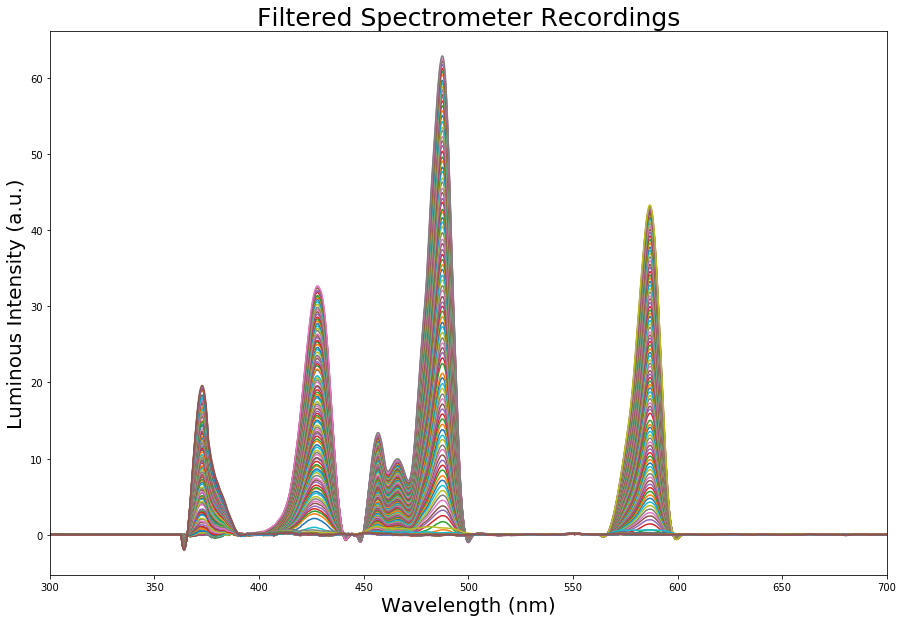

In [6]:
savgolWindow = 61   # The length of the filter window
savgolOrder = 2     # The order of the polynomial used to fit the samples.
savgolDelta = 1     # The spacing of the samples to which the filter will be applied.

Smoothed = savgol(Spectra, savgolWindow, savgolOrder, delta = savgolDelta, axis = -1)
Smoothed = Smoothed.reshape(nLED,nPoints,-1)
Smoothed = Smoothed[:,:-1,:]

fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])]

ax.set_title('Filtered Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange));


## Determine peak wavelength for each LED in nm

In [7]:
sm = 80
MaxesIndices = np.argmax(Smoothed[:,sm,:],axis = -1)

Peaks = WvsX[MaxesIndices]
Peaks = np.around(Peaks,decimals=1)

Peak = [['','Red ','Green ','Blue ','UV '],
        ['Peak Wavelength (nm)',Peaks[0],Peaks[1],Peaks[2],Peaks[3]],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in Peak)
       )
))

,Red,Green,Blue,UV
Peak Wavelength (nm),586.9,487.7,427.9,372.8



## Plot LED spectra

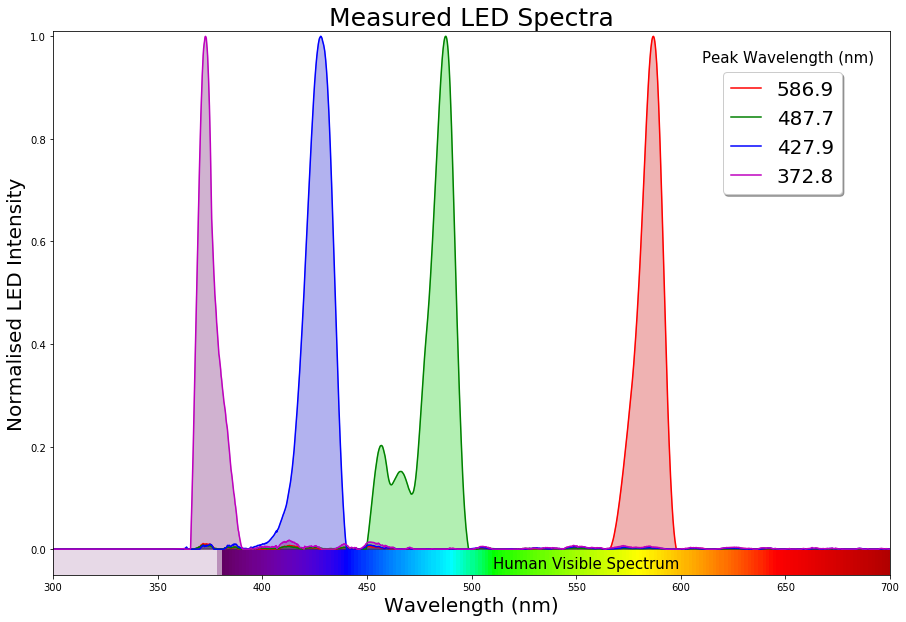

In [8]:
RedLEDNormalised = Smoothed[0,sm,:]/np.amax(Smoothed[0,sm,:])
GreenLEDNormalised = Smoothed[1,sm,:]/np.amax(Smoothed[1,sm,:])
BlueLEDNormalised = Smoothed[2,sm,:]/np.amax(Smoothed[2,sm,:])
UVLEDNormalised = Smoothed[3,sm,:]/np.amax(Smoothed[3,sm,:])

RedLEDnormalised = np.copy(RedLEDNormalised)
RedLEDnormalised[RedLEDnormalised<0] = 0
GreenLEDnormalised = np.copy(GreenLEDNormalised)
GreenLEDnormalised[GreenLEDnormalised<0] = 0
BlueLEDnormalised = np.copy(BlueLEDNormalised)
BlueLEDnormalised[BlueLEDnormalised<0] = 0
UVLEDnormalised = np.copy(UVLEDNormalised)
UVLEDnormalised[UVLEDnormalised<0] = 0

LEDnormalised = np.zeros((nLED,len(WvsX)))
LEDnormalised = (RedLEDnormalised[:],GreenLEDnormalised[:],BlueLEDnormalised[:],UVLEDnormalised[:])

LEDint = np.zeros((nLED))
for iLED in range (nLED):
    LEDint[:] = np.sum(LEDnormalised[iLED])

normLED = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    normLED[iLED] = np.divide(LEDnormalised[iLED],LEDint[iLED])
    
    
RGBA=[(0.8,0,0,0.3),(0,0.8,0,0.3),(0,0,0.8,0.3),(0.4,0,0.4,0.3)]
    
fig,ax = plt.subplots(1,1,figsize = FigureSize)

for iLED in range (nLED):
    ax.plot(WvsX,LEDnormalised[iLED],colour[iLED])
    ax.fill(WvsX,LEDnormalised[iLED],c=RGBA[iLED])
    
plt.legend((Peaks[0], Peaks[1], Peaks[2], Peaks[3]), shadow=True, loc=(0.8, 0.7), handlelength=1.5, fontsize=20)

ax.set_title('Measured LED Spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised LED Intensity', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)
plt.text(610,0.95, 'Peak Wavelength (nm)', fontsize=15);

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);

***

# Generate Opsin Template
This code fits Govardovskii (A1 pigment) templates to desired peak wavelengths: lambdamax [Govardovskii et al.](https://www.cambridge.org/core/journals/visual-neuroscience/article/in-search-of-the-visual-pigment-template/A4738E821720092B7F5A233C4AB4962B) (In search of the visual pigment template, 2000). Itself adapted from the template described by [Lamb et al](https://www.sciencedirect.com/science/article/pii/004269899500114F?via%3Dihub) (Photoreceptor Spectral Sensitivities:Common Shape in the Long-wavelength Region, 1995)

***

#### AlphaBand     $$S\alpha(x) = \frac{1}{exp[A(a-x)] + exp[B(b-x)] + exp[C(c-x)] + D}$$

Where $x$ = $\frac{\lambda max}{\lambda}$

With $a$ the only variable parameter such as $a$ = $0.8795 + 0.0459 * exp^{\frac{(\lambda max -300)^{2}}{11940}}$, and constant parameters (A, B, b, C, c, D) as defined below.

***

#### BetaBand      $$S\beta(\lambda) = A\beta * exp^{-(\frac{\lambda - \lambda m\beta}{b})^{2}}$$

With $A_{\beta}$  the amplitude of the $\beta band$ relative to the $\alpha band$, $\lambda m_{\beta}$ the position of the $\beta peak$ and $b$ a bandwidth parameter


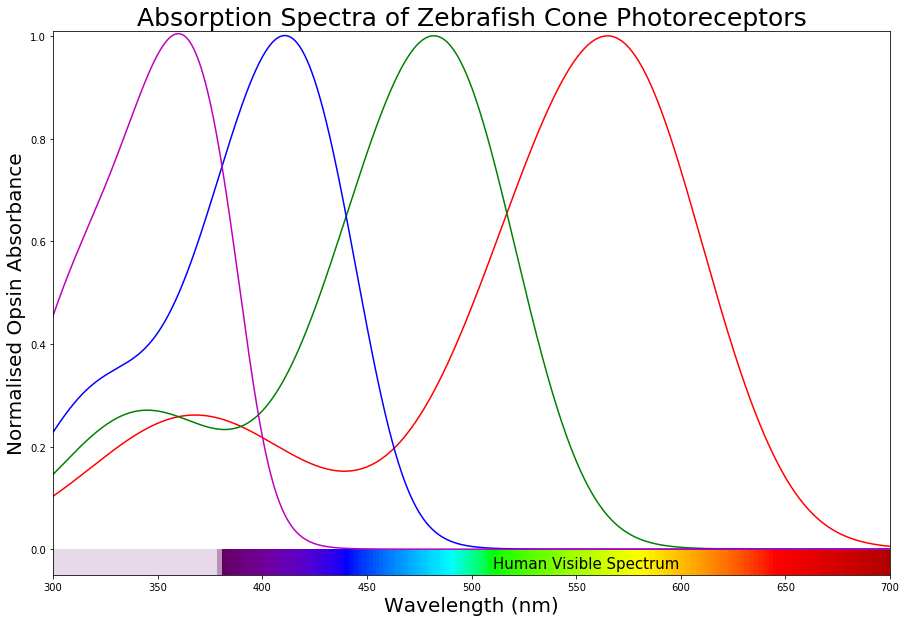

In [9]:
''' 
This part of the code uses the absorbance spectrum fitting template for visual pigment 
defined by Govardoskii et al (In Search of Visual Pigment Template, 2000).                                                                               
'''

def Govardovskii (wvsloc, lambdamax): # This function returns one sensitivity spectrum point y at wavelength = wvs of an opsin  with a peak at lambdamax, wvs - such wavelengths at which the template will be evaluated: 1d-array lambdamax - peak of the sensitivity spectrum'''
   
   wvs = np.asarray(wvsloc)
    
   ## Alpha Band ##
   A = 69.7
   a = 0.8795+0.0459*np.exp(-np.square(lambdamax-300)/11940)
   B = 28
   b = 0.922
   C = -14.9
   c = 1.104
   D = 0.674
   x = lambdamax/wvs
   alphaband = 1/ (np.exp(A*(a-x))+np.exp(B*(b-x))+np.exp(C*(c-x))+D)
   
   ## Beta Band ##
   Ab = 0.26 #Beta value at peak
   b = -40.5+0.195*lambdamax #Beta bandwidth
   mb = 189+0.315*lambdamax #Beta peak
   betaband = Ab * np.exp(-1*((wvs-mb)/b)**2)
    
   return alphaband+betaband


red = Govardovskii(WvsX,PeakWavelength[0])
green = Govardovskii(WvsX,PeakWavelength[1])
blue = Govardovskii(WvsX,PeakWavelength[2])
uv = Govardovskii(WvsX,PeakWavelength[3])

Opsin = np.zeros((len(WvsX),nLED))
Opsin = (red,green,blue,uv)



fig,ax = plt.subplots(1,1,figsize = FigureSize)
for iCone in range (nCone):
    ax.plot(WvsX,Opsin[iCone],c=colour[iCone])

ax.set_title('Absorption Spectra of Zebrafish Cone Photoreceptors', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Opsin Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);

# Plot LED spectra against the zebrafish cone action spectra. 
Graph includes the PMT detector bands

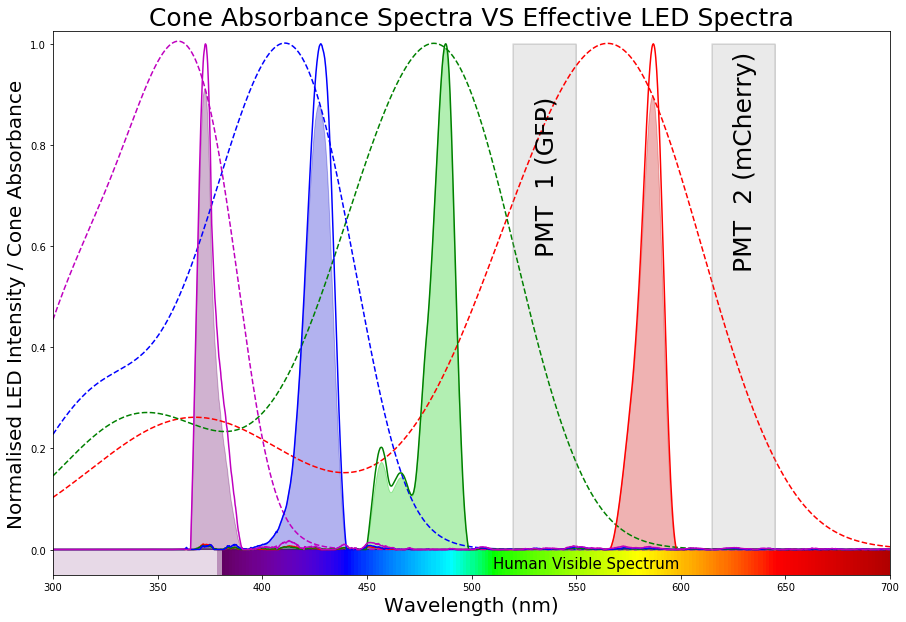

In [10]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

for iCone in range (nCone):
    ax.plot(WvsX,Opsin[iCone],Colour[iCone])
for iLED in range (nLED):
    ax.plot(WvsX,LEDnormalised[iLED],colour[iLED])
    ax.fill(WvsX,np.multiply(Opsin[iLED],LEDnormalised[iLED]),c=RGBA[iLED])

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.025)

plt.plot([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.6,0.6,0.6,0.3))
ax.fill([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.6,0.6,0.6,0.2))
plt.text(PMT1_min+10, 0.66+0.2, 'PMT  1 (GFP)', fontsize=25, rotation=90)

plt.plot([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.6,0.6,0.6,0.3))
ax.fill([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.6,0.6,0.6,0.2))
plt.text(PMT2_min+10, 0.749+0.2, 'PMT  2 (mCherry)', fontsize=25, rotation=90)

ax.set_title('Cone Absorbance Spectra VS Effective LED Spectra', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = FigureFontSize)


ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum',color = 'black',fontsize=15);

***

Generate heatmap template for display purposes

In [11]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,fontsize=FigureFontSize)
    ax.set_yticklabels(row_labels,fontsize=FigureFontSize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, left = True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",textcolors=["black", "black"],threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts



# Estimate relative co-excitation of photoreceptors by the LEDs

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


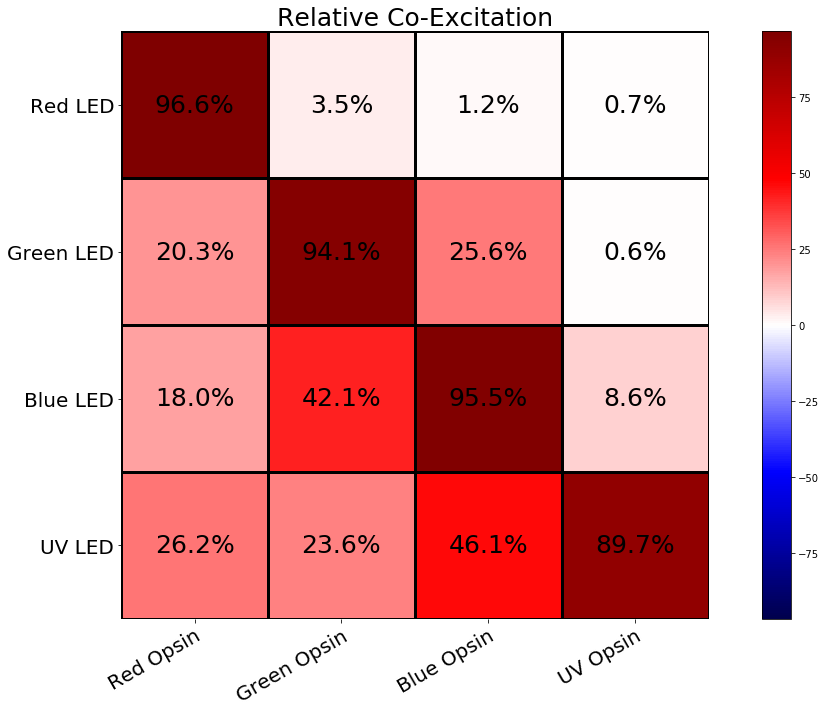

In [12]:
# Calculates M and N matrices for silent substitution: M, N
Ops = np.asarray([Govardovskii (WvsX, Peaks[i]) for i in [0,1,2,3]])
Ops = Ops.swapaxes(1,0)

Led = np.zeros((1025, nLED))
for jj in range (0,nLED):
    Led = [RedLEDnormalised,GreenLEDnormalised,BlueLEDnormalised,UVLEDnormalised]

Led = np.asarray(Led).T


M0 = np.zeros((nCone,nLED, len(Led[:,0]))) #M0 is needed to take integrals over LED*OPS
M = np.zeros((nCone,nLED)) #M1 is the M matrix of Estevez, gives vector of response changes (r) from vector of stimulus changes (s): r = M1*s
M1 = np.zeros((nCone,nLED))


for iCone in range(0,(nCone)):              # For each cone...
    for iLED in range(0,(nLED)):               # For each LED...
        M0[iCone,iLED,:] = Ops[:,iCone]*Led[:,iLED]           # Multiply Ops and Led elements 
        M[iCone,iLED] = np.sum(M0[iCone,iLED,:])              # Generate a cross activation integral M = (Ops*Led)
        M1[iCone,iLED] = M[iCone,iLED]/np.sum(Led[:,iLED])     # Divide the cross activation integral by the LED integral M1 = M/Led

def normalise (myarray): #define a normalisation function
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray
        
# Display M matrix
M1_Matrix = M1*100
M1_Matrix = M1_Matrix.swapaxes(1,0)
vmx = np.amax(np.abs(M1_Matrix.reshape(-1)))
vmn = - vmx

Cones = ["Red Opsin", "Green Opsin", "Blue Opsin", "UV Opsin"]
LEDs = ["Red LED", "Green LED", "Blue LED","UV LED"]

ax.set_xticks(np.arange(len(LEDs)))
ax.set_yticks(np.arange(len(Cones)))
ax.set_xticklabels(LEDs)
ax.set_yticklabels(Cones)

plt.setp(ax.get_xticklabels(), rotation=45, ha="left",rotation_mode="anchor")

fig, (ax1) = plt.subplots(1, 1, figsize=FigureSize)

im, _ = heatmap(M1_Matrix, LEDs, Cones, ax=ax1, cmap="seismic", vmax = vmx, vmin = vmn)
annotate_heatmap(im, valfmt="{x:.1f}%", size=FigureFontSize+5)

ax1.set_title('Relative Co-Excitation', fontsize = FigureTitleSize)

fig.tight_layout();

# Extract Powermeter Recording to determine the electrical power (in nW)
Here, we used an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany).

The following script is configured by default for ThorLab Powermeter recording in .csv format.

In [13]:
'''Powermeter Recording General Parameters'''

r_sensor_um = (9.5/2)*1000
SensorArea = np.pi*(r_sensor_um**2)

Steps = 255
Red_FirstRecording = 22
Red_LastRecording = Red_FirstRecording + Steps
Green_FirstRecording = 28
Green_LastRecording = Green_FirstRecording + Steps
Blue_FirstRecording = 27
Blue_LastRecording = Blue_FirstRecording + Steps
UV_FirstRecording = 22
UV_LastRecording = UV_FirstRecording + Steps

Red_FileName = 'Red.csv'
Green_FileName = 'Green.csv'
Blue_FileName = 'Blue.csv'
UV_FileName = 'UV.csv'

# Plot Energy Readings and Irradiance of each LED 

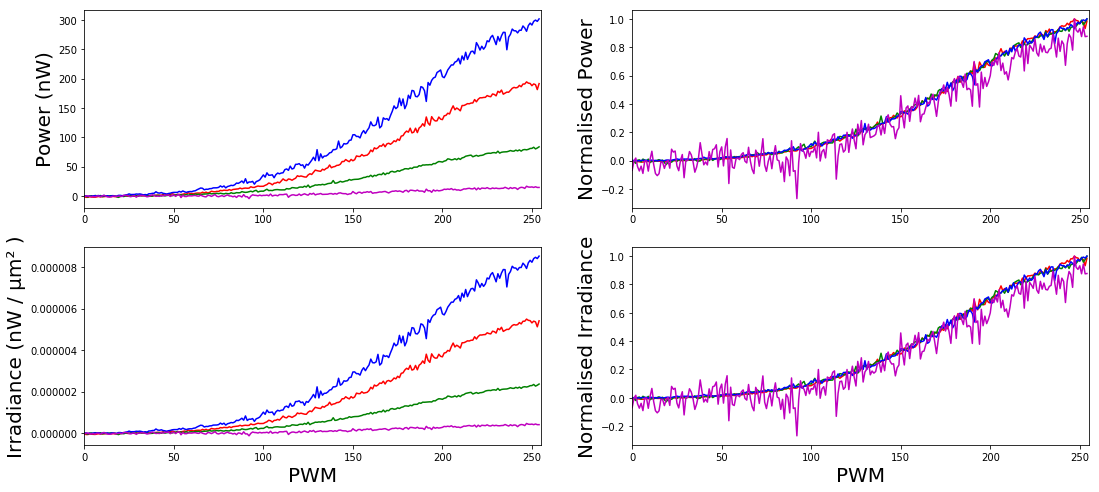

In [14]:
powermeter_red = pd.read_csv(Red_FileName, sep = ';',skiprows = Red_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_red = np.asarray(powermeter_red.power)[:Steps]*10**9
Irradiance_red = np.asarray(powermeter_red.irradiance)[:Steps]*10

powermeter_green = pd.read_csv(Green_FileName, sep = ';',skiprows = Green_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_green = np.asarray(powermeter_green.power)[:Steps]*10**9
Irradiance_green = np.asarray(powermeter_green.irradiance)[:Steps]*10

powermeter_blue= pd.read_csv(Blue_FileName, sep = ';',skiprows = Blue_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_blue = np.asarray(powermeter_blue.power)[:Steps]*10**9
Irradiance_blue = np.asarray(powermeter_blue.irradiance)[:Steps]*10

powermeter_uv = pd.read_csv(UV_FileName, sep = ';',skiprows = UV_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_uv = np.asarray(powermeter_uv.power)[:Steps]*10**9
Irradiance_uv = np.asarray(powermeter_uv.irradiance)[:Steps]*10

norm_power_red = normalise(Power_red)
norm_power_green = normalise(Power_green)
norm_power_blue = normalise(Power_blue)
norm_power_uv = normalise(Power_uv)

norm_irradiance_red = normalise(Irradiance_red)
norm_irradiance_green = normalise(Irradiance_green)
norm_irradiance_blue = normalise(Irradiance_blue)
norm_irradiance_uv = normalise(Irradiance_uv)

Power = np.zeros((nLED,Steps))
Power = (Power_red,Power_green,Power_blue,Power_uv)

Norm_Power = np.zeros((nLED,Steps))
Norm_Power = (norm_power_red,norm_power_green,norm_power_blue,norm_power_uv)

Irradiance = np.zeros((nLED,Steps))
Irradiance = (Irradiance_red,Irradiance_green,Irradiance_blue,Irradiance_uv)

Norm_Irradiance = np.zeros((nLED,Steps))
Norm_Irradiance = (norm_irradiance_red,norm_irradiance_green,norm_irradiance_blue,norm_irradiance_uv)

#pmre = np.asarray([np.amax(Power_red),np.amax(Power_green),np.amax(Power_blue),np.amax(Power_uv)])*10**69 #powermeter readings, (nW)

y_Steps = np.arange(0,Steps,1)
fig,ax = plt.subplots(2,2,figsize = (18,8))

for iLED in range (nLED):
    ax[0,0].plot(y_Steps,Power[iLED],c=colour[iLED])
    ax[0,1].plot(y_Steps,Norm_Power[iLED],c=colour[iLED])
    ax[1,0].plot(y_Steps,Irradiance[iLED],c=colour[iLED])
    ax[1,1].plot(y_Steps,Norm_Irradiance[iLED],c=colour[iLED])

ax[0,0].set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax[0,0].set_xlim(0,255);

ax[0,1].set_ylabel('Normalised Power', fontsize = FigureFontSize);
ax[0,1].set_xlim(0,255);

ax[1,0].set_xlabel('PWM', fontsize = FigureFontSize)
ax[1,0].set_ylabel('Irradiance (nW / μm² )', fontsize = FigureFontSize)
ax[1,0].set_xlim(0,255);

ax[1,1].set_xlabel('PWM', fontsize = FigureFontSize)
ax[1,1].set_ylabel('Normalised Irradiance', fontsize = FigureFontSize);
ax[1,1].set_xlim(0,255);

# Determine Photo-Isomerisation Rates for all LED and Photoreceptor combinations

## Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


***

## Determining the photon density flux density $P_{E}(\lambda)$ for each LED

#### Calculate the wavelength-dependent photon energy Q in $eV$

In [15]:
h = 4.135667E-15 # Planck's constant [eV*s]
c = 299792458    # speed of light [m/s]

Power_Q = np.array((c*h/(WvsX *1E-9)), dtype=float)

#### Convert Energy Flux from $nW$ into $eV . s^{-1}$ for each LED recording

In [16]:
eV_per_J = 6.242E+18    # [eV] per [J]

Pow_eFlux = np.zeros((nLED,Steps))
for iLED in range (nLED):
    Pow_eFlux[iLED,:] = np.multiply(Power[iLED]*10**-9,eV_per_J)
    
Irr_eFlux = np.zeros((nLED,Steps))
for iLED in range (nLED):
    Irr_eFlux[iLED,:] = np.multiply(Irradiance[iLED]*10**-9,eV_per_J)
    

#### Report for each LED, the Energy Flux mesured at max intensity (PWM = 255) to the normalised LED spectra integrals  


In [17]:
Power_eFlux = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Power_eFlux[iLED,:] = np.multiply(Pow_eFlux[iLED,-1],normLED[iLED,:])

    
Irradiance_eFlux = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Irradiance_eFlux[iLED,:] = np.multiply(Irr_eFlux[iLED,-1],normLED[iLED,:])

#### Divide Energy Flux by the Photon Energy to get the Photon Flux $\phi$ ($photons . s^{-1} $) 

In [18]:
Power_Phi = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Power_Phi[iLED] = np.divide(Power_eFlux[iLED],Power_Q)
    
Irradiance_Phi = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Irradiance_Phi[iLED] = np.divide(Irradiance_eFlux[iLED],Power_Q)

#### Finally determine Photon Flux Density $P_{E}(\lambda)$ ($photons . s^{-1} . µm^{-2}$)

In [19]:
Power_E = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Power_E[iLED] = np.divide(Power_Phi[iLED],SensorArea)
    
Irradiance_E = Irradiance_Phi

#### Determine the Photon Flux Density per LED from the Irradiance Recording

In [20]:
IntIrradiance_E = np.zeros((nLED))
for iLED in range(nLED):
    IntIrradiance_E[iLED] = np.sum(Irradiance_E[iLED])
    
print('Red LED = ' + str(IntIrradiance_E[0]) + ' photon/s/µ𝑚2')
print('Green LED = ' + str(IntIrradiance_E[1]) + ' photon/s/µ𝑚2')
print('Blue LED = ' + str(IntIrradiance_E[2]) + ' photon/s/µ𝑚2')
print('UV LED = ' + str(IntIrradiance_E[3]) + ' photon/s/µ𝑚2')

Red LED = 18323.17606808571 photon/s/µ𝑚2
Green LED = 8223.354093697539 photon/s/µ𝑚2
Blue LED = 26019.485785540688 photon/s/µ𝑚2
UV LED = 823.754119832456 photon/s/µ𝑚2


***

## Determining the Light Collection Area of cone outer segments

 ### $A_{collect} = OSA . \gamma . 1-10^{\alpha . OSL}$

Whith

OSA the Outer Segment Area

$\gamma$ the quantum efficiency of the opsin change

$\alpha$ the cone specific absorption coefficient 

OSL the Outer Segment Length

#### Set Cones physiological features

In [21]:
# Outer Segment Diameter for R,G,B & UV cones in µm. 
# Allison et al. 2004 - Visual pigment composition in zebrafish
OSD = np.asarray([2.4, 2.4, 2.8, 2.6], dtype = np.float64) 

# Outer Segment Area
OSA = np.pi*(OSD[:]/2)**2

# Outer Segment Length in µm 
# Branchek et al. 1984 - The development of photoreceptors in the zebrafish, Brachydanio rerio. I. Structure 
OSL = [10, 10, 7.6, 10]

# Specific Absorbance for R,G,B & UV opsins in µm-1
# Allison et al. 2004 - Visual pigment composition in zebrafish
Alpha = [0.0073, 0.0063, 0.007, 0.0054] 

# Quantum efficiency of the opsin change (p(Photoisomerisation/Light being absorbed)) 
# Dartnall et al. 1967 - The photosensitivities of visual pigments in the presence of hydroxylamine
Gamma = 0.67 

#### Determine the Specific Absorption Coefficient $1-10^{\alpha . OSL}$ 

Also known as the Specific Optical Density, it is defined as the fraction of light absorbed per infinitesimal unit length of photopigment. It depends only on the absorption properties of the photopigment.

In [22]:
Absorption_coef = np.zeros((nCone))
for iCone in range (nCone):
    Absorption_coef[iCone] = 1-(10**(-Alpha[iCone]*OSL[iCone]))

#### Finally determine the Light Collection Area $A_{collect}$ = OSA . $\gamma$ . Absorption Coefficient

In [23]:
A_Collect = np.zeros((nCone))
for iCone in range (nCone):
    A_Collect[iCone] = OSA[iCone] * Gamma * Absorption_coef[iCone] 

***

## Finally, determine the Photo-isomerisation state for each opsin and LED combinations

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


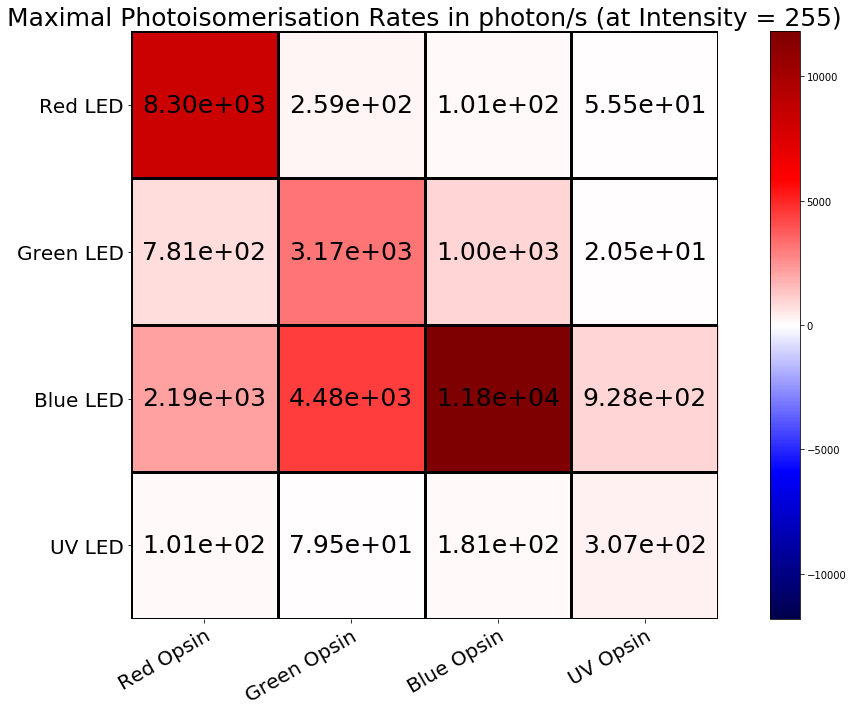

In [24]:
M1_Isomerisation =np.zeros((nCone,nLED))
for iCone in range(nCone):              # For each cone...
    for iLED in range(nLED):               # For each LED...
        M1_Isomerisation[iCone,iLED] = M1[iCone,iLED] * IntIrradiance_E[iLED] * A_Collect[iCone]

M1_Isomerisation = M1_Isomerisation.swapaxes(1,0)
vmaxMiso = np.amax(np.abs(M1_Isomerisation.reshape(-1)))
vminMiso = - vmaxMiso   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(M1_Isomerisation, LEDs, Cones, ax=ax, cmap="seismic", vmax = vmaxMiso, vmin = vminMiso)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Maximal Photoisomerisation Rates in photon/s (at Intensity = 255)', fontsize = FigureTitleSize)
fig.tight_layout()